In [1]:
import numpy as np
from itertools import product
from qiskit.quantum_info import Statevector
from qutip import sigmax, sigmay, sigmaz, qeye, tensor, qzero, Qobj, simdiag, about
import qutip as qt
from scipy.linalg import logm
from sympy import Matrix

from IPython.display import display
import matplotlib as mpl
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'

# $\text{Generate } \text{VTA} $

In [2]:
# functions necessary to generate VTA through SU(2) expansion 
def generate_SWAP_operators(N, Jx, Jy, Jz):
    
    '''
    generate list of SWAP operators that needed to compute VTA 
    using the SU(2) expansion method
    '''
    
    if N % 2 != 0: 
        raise ValueError("Please enter an even number of sites.")
        
    # define zero and identity matrices corresponding to dimensions of VTA
    zeros_N = qzero([2]*N)
    I_N = qeye([2]*N)
    
    # define Pauli matrices and constants
    σ_x = sigmax()
    σ_y = sigmay()
    σ_z = sigmaz()
    
    # Interaction coefficients, which we assume are uniform throughout the lattice
    Jx_list = Jx*np.ones(N)
    Jy_list = Jy*np.ones(N)
    Jz_list = Jz*np.ones(N)

    # Setup operators for individual qubits; 
    # here σ_x_list[j] = X_j, σ_y_list[j] = Y_j, and σ_z_list[j] = Z_j
    # since the Pauli matrix occupies the jth location in the tensor product of N terms
    # for which (N-1) terms are the identity
    σ_x_list, σ_y_list, σ_z_list = [], [], []

    for i in range(N):
        op_list = [qeye(2)]*N
        op_list[i] = σ_x
        σ_x_list.append(tensor(op_list))
        op_list[i] = σ_y
        σ_y_list.append(tensor(op_list))
        op_list[i] = σ_z
        σ_z_list.append(tensor(op_list))

    # define empty lists for + and - projection operators
    π_list = []
    
    # collect list of all tuples corresponding to π_p and π_m 
    # SWAP operators
    for k in range(N):

        # find H_ij, the Hamiltonian between the ith and jth sites 
        H_kl = Jx_list[k] * σ_x_list[k] * σ_x_list[(k + 1) % N] + \
               Jy_list[k] * σ_y_list[k] * σ_y_list[(k + 1) % N] + \
               Jz_list[k] * σ_z_list[k] * σ_z_list[(k + 1) % N]
        
        # add π_p to π_m to π_p_list and π_m_list, respectively
        π_p = (3 + H_kl)/4
        π_m = (1 - H_kl)/4
        π_list.append((π_p, π_m))
    
    # check to ensure projectors obey established summation and orthogonality relations
    π_kl_bool_list = []
    for π_kl in π_list: 
        π_kl_bool_list.append(π_kl[0] * π_kl[1] == zeros_N and \
                              π_kl[0] + π_kl[1] == I_N)

    if all(π_kl_bool_list):
#         display(Latex(r'$ \pi^{+}_{kl} \pi^{-}_{kl} = 0 \text{ and } $'
#                       r'$\pi^{+}_{kl} + \pi^{-}_{kl} = \mathbb{1}$' 
#                      rf'$ \ \forall \ k,l \in \{{1, \dots, {N} \}}$'))
        return π_list
    else: 
        display(Latex(r'$ \pi^{+}_{kl} \pi^{-}_{kl} \neq 0 \text{ of } $'
                      r'$\pi^{+}_{kl} + \pi^{-}_{kl} \neq \mathbb{1}$' 
                     rf'$ \ \forall \ k,l \in \{{1, \dots, {N} \}}$'))
        raise ValueError(f'SWAP operators do not obey the desired summation and' + \
                          ' orthogonality conditions')
def MPO(π_list, α, E_0, b7, b6, b5, b4, b3, b2, b1, b0):
    
    '''
    generate matrix product operator corresponding to a unique α 
    and set of eight indices
    '''
    
    # define projection operators where π_kl is a tuple 
    # such that π_kl[0] = π^{+}_{kl} and π_kl[1] = π^{-}_{kl}
    π12 = π_list[0]
    π23 = π_list[1]
    π34 = π_list[2]
    π41 = π_list[3]

    # define constant q
    q = 2 + E_0/2
    
    # return matrix product operator for a given α and set of indices
    return np.exp((-2*α**2) * (
           (q - 4 + 2*(b0 + b3 + b5 + b6))**2 + \
           (q - 4 + 2*(b0 + b2 + b5 + b7))**2 + \
           (q - 4 + 2*(b1 + b2 + b4 + b7))**2 + \
           (q - 4 + 2*(b1 + b3 + b4 + b6))**2)) * \
            π41[b7]*π23[b6]*π34[b5]*π12[b4] * \
            π41[b3]*π23[b2]*π34[b1]*π12[b0]
def SU2_expansion(N, α_start, α_end, α_steps, Jx, Jy, Jz, E_0): 
    
    '''
    compute list of VTAs using an efficient, automated approach
    '''
    
    # define array over which we will sweep α
    α_array = np.linspace(α_start, α_end, α_steps)
    
    # collect list of SWAP operators
    π_list = generate_SWAP_operators(N, Jx, Jy, Jz)

    # generate all possible combinations of tuples 
    combination_tuples = list(product([0, 1], repeat=int(N*(N/2))))
    
    # return the sum of all VTA
    return [sum(MPO(π_list, α, E_0, *combination) \
                for combination in combination_tuples) \
                for α in α_array]

In [3]:
N = 4
α_start = 0
α_end = 1
α_steps = 101
Jx = 1
Jy = 1
Jz = 1
E_0 = -8

# find VTA for α = 1
VTA_list = SU2_expansion(N, α_start, α_end, α_steps, Jx, Jy, Jz, E_0)

In [4]:
# generate array over which we swept α in SU2_expansion
α_array = np.linspace(α_start, α_end, α_steps)

# $\text{Generate } \mathcal{G} $

In [5]:
def spin_chain(N, Jx, Jy, Jz, periodic_bc):

    
    if N % 2 != 0: 
        raise ValueError("Please enter an even number of sites")
    
    # define Pauli matrices and constants
    σ_x = sigmax()
    σ_y = sigmay()
    σ_z = sigmaz()
    π = np.pi

    # Interaction coefficients, which we assume are uniform throughout the lattice
    Jx_list = Jx*np.ones(N)
    Jy_list = Jy*np.ones(N)
    Jz_list = Jz*np.ones(N)

    # Setup operators for individual qubits; 
    # here sx_list[j] = X_j, sy_list[j] = Y_j, and sz_list[j] = Z_j
    # since the Pauli matrix occupies the jth location in the tensor product of N terms
    # of which N-1 terms are the identity
    sx_list, sy_list, sz_list = [], [], []

    for i in range(N):
        op_list = [qeye(2)]*N
        op_list[i] = σ_x
        sx_list.append(tensor(op_list))
        op_list[i] = σ_y
        sy_list.append(tensor(op_list))
        op_list[i] = σ_z
        sz_list.append(tensor(op_list))

    # define variable for total Hamiltonian H_N and the list of all local 
    # Hamiltonians H_list
    HN = 0 
    H_list = []
    
    # collect 
    for j in range(N - 1):

        # find H_ij, the Hamiltonian between the ith and jth sites 
        H_ij = Jx_list[j] * sx_list[j] * sx_list[j + 1] + \
               Jy_list[j] * sy_list[j] * sy_list[j + 1] + \
               Jz_list[j] * sz_list[j] * sz_list[j + 1]
        
        # add H_ij to H_N and append H_ij to H_list
        HN += H_ij

    # execute if periodic boundary conditions are specified
    if periodic_bc: 
        
        # find H_N1, the Hamiltonian between the Nth and first site
        H_N1 = Jx_list[N-1] * sx_list[N - 1] * sx_list[0] + \
               Jy_list[N-1] * sy_list[N - 1] * sy_list[0] + \
               Jz_list[N-1] * sz_list[N - 1] * sz_list[0]

        # add H_N1 to H_N and append H_N1 to H_list
        HN += H_N1
        
    # compute ground state energy of HN
    # E0 = HN.groundstate()[0]
    
    # compute HN eigenstates
    eigenstates = HN.eigenstates()[1]
    
    # compute density matrix of groundstate
    ρ_list = [eigvec*eigvec.dag() for eigvec in eigenstates]
        
    return eigenstates, ρ_list, HN, (sx_list, sy_list, sz_list)

In [6]:
# define a spin chain with four sites, equal coupling constants
# and periodic boundary conditions
N = 4
Jx = 1
Jy = 1
Jz = 1
periodic_bc = True

eigvecs, ρ_list, HN, vS = spin_chain(N, Jx, Jy, Jz, periodic_bc)

swap24 = 0.5*sum(vS[n][2-1]*vS[n][4-1] for n in [0,1,2]) + 0.5*qeye([2]*N)
S2 = sum(sum(vS[n])**2 for n in [0,1,2])/4  #1/4 factor: pauli to spin
Sz = sum(vS[2])/2
eigEsym, eigVsym = simdiag([HN, S2, Sz, swap24])
eigEsym = eigEsym.T

eigvecs = eigVsym  #replace with symmetry eigenvecs
ρ_list = [eigvec*eigvec.dag() for eigvec in eigvecs]

In [7]:
eigVsym_fp = eigVsym.copy()  #new obj. to hold the fixed phase eigenvectors
for ii in range(2**4):
    print(ii)
    if np.sqrt((eigEsym[ii,0]-(-8))**2 + (eigEsym[ii,1]-0)**2) < 1e-10:  #|λ0>: E=-8, s(s+1)=0
        vec = eigVsym_fp[ii].data_as()
        c0011 = vec[3] #int('0011',base=2)==3
        eigVsym_fp[ii] *= -np.exp(-1j*np.angle(c0011))  #make c0011<0, see Eq. (513) in the notes
        vec = eigVsym_fp[ii].data_as()
        display(Statevector(vec).draw('latex'))
    elif np.sqrt((eigEsym[ii,0]-0)**2 + (eigEsym[ii,1]-0)**2) < 1e-10:  #|λ1>: E=0, s(s+1)=0
        vec = eigVsym_fp[ii].data_as()
        c0011 = vec[3] #int('0011',base=2)==3
        eigVsym_fp[ii] *= np.exp(-1j*np.angle(c0011)) #make c0011>0, see Eq. (514) in the notes
        vec = eigVsym_fp[ii].data_as()
        display(Statevector(vec).draw('latex'))        
    else:
        continue
        #continue  #uncomment this line to skip the code below that fixes other phases (optional, because phases cancel in |E_k><E_k|)
#         vec = eigVsym_fp[ii].data_as()
#         c_idx = np.where(abs(vec)>1e-10)[0][0]  #first nonzero element
#         c = vec[c_idx]
#         eigVsym_fp[ii] *= np.exp(-1j*np.angle(c))
#         vec = eigVsym_fp[ii].data_as()
#         display(Statevector(vec).draw('latex'))
        

eigvecs = eigVsym_fp
ρ_list = [eigvec*eigvec.dag() for eigvec in eigvecs]

0


<IPython.core.display.Latex object>

1
2
3
4


<IPython.core.display.Latex object>

5
6
7
8
9
10
11
12
13
14
15


In [8]:
# G(α, Es) basis functions
e0 = lambda α, Es: np.exp(-2*(α**2)*((Es + 12)**2)) 
e1 = lambda α, Es: np.exp(-2*(α**2)*((Es + 8)**2)) 
e2 = lambda α, Es: np.exp(-2*(α**2)*((Es + 4)**2)) 
e3 = lambda α, Es: np.exp(-2*(α**2)*(Es**2)) 
e4 = lambda α, Es: np.exp(-2*(α**2)*((Es - 4)**2))
e5 = lambda α, Es: np.exp(-2*(α**2)*((Es + 2)**2 + 4))
e6 = lambda α, Es: np.exp(-2*(α**2)*((Es + 2)**2 + 20))
e7 = lambda α, Es: np.exp(-2*(α**2)*(Es**2 + 8))
e8 = lambda α, Es: np.exp(-2*(α**2)*((Es + 4)**2 + 16))
e9 = lambda α, Es: np.exp(-2*(α**2)*(Es**2 + 16))
e10= lambda α, Es: np.exp(-2*(α**2)*((Es + 4)**2 + 32))

# G(α, Es) coefficients
g00 = lambda α, Es: (3*e0(α, Es) + 24*e1(α, Es) \
                     + 6*e2(α, Es) - e4(α, Es))/32
g44 = lambda α, Es: -(e0(α, Es) - 6*e2(α, Es) \
                      - 24*e3(α, Es) - 3*e4(α, Es))/32
g04 = lambda α, Es: (np.sqrt(3)*(e0(α, Es) + 4*e1(α, Es) - \
                     10*e2(α, Es) + 4*e3(α, Es) + e4(α, Es)))/32
g40 = lambda α, Es: - g04(α, Es)
gt = lambda α, Es: (e10(α, Es) + e2(α, Es) + 4*e5(α, Es) - 4*e6(α, Es) + \
                    2*e8(α, Es))/4
gs = lambda α, Es: (e3(α, Es) + e5(α, Es) - e6(α, Es) + e9(α, Es))/2
gq = lambda α, Es: e4(α, Es)

In [9]:
# define G as a function of α and Es
G = lambda α, Es: \
    g00(α, Es)*ρ_list[0] + \
    g04(α, Es)*eigvecs[0]*eigvecs[4].dag() + \
    g40(α, Es)*eigvecs[4]*eigvecs[0].dag() + \
    g44(α, Es)*ρ_list[4] + \
    gt(α, Es)*sum(ρ_list[1:4]) + \
    gs(α, Es)*sum(ρ_list[5:11]) + \
    gq(α, Es)*sum(ρ_list[11:16])

In [10]:
# compute log(G) for α = 1
Es = E_0 #-8
G_list = [G(α, Es).tidyup() for α in α_array]

In [11]:
VTA_list[-1] ==  G_list[-1]

True

In [12]:
VTA_list[1] == G_list[1]

True

In [15]:
VTA_list == G_list

True

In [17]:
G_list[3]

Quantum object: dims=[[2, 2, 2, 2], [2, 2, 2, 2]], shape=(16, 16), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 0.77166867  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.88145042 -0.04974291  0.         -0.01029593  0.
   0.          0.         -0.04974291  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.         -0.04974291  0.88145042  0.         -0.04974291  0.
   0.          0.         -0.01029593  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.88088445  0.         -0.0315375
  -0.01763944  0.          0.         -0.01763944 -0.0315375   0.
  -0.0108619   0.          0.          0.        ]
 [ 0.         -0.01029593 -0.04974291  0.          0.88145042  0.
   0.          0.         -0.04974291  0.          0.          0.
   0.      

In [18]:
VTA_list[3]

Quantum object: dims=[[2, 2, 2, 2], [2, 2, 2, 2]], shape=(16, 16), type='oper', dtype=CSR, isherm=False
Qobj data =
[[ 0.77166867  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.88145042 -0.04974291  0.         -0.01029593  0.
   0.          0.         -0.04974291  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.         -0.04974291  0.88145042  0.         -0.04974291  0.
   0.          0.         -0.01029593  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.88088445  0.         -0.0315375
  -0.01763944  0.          0.         -0.01763944 -0.0315375   0.
  -0.0108619   0.          0.          0.        ]
 [ 0.         -0.01029593 -0.04974291  0.          0.88145042  0.
   0.          0.         -0.04974291  0.          0.          0.
   0.        

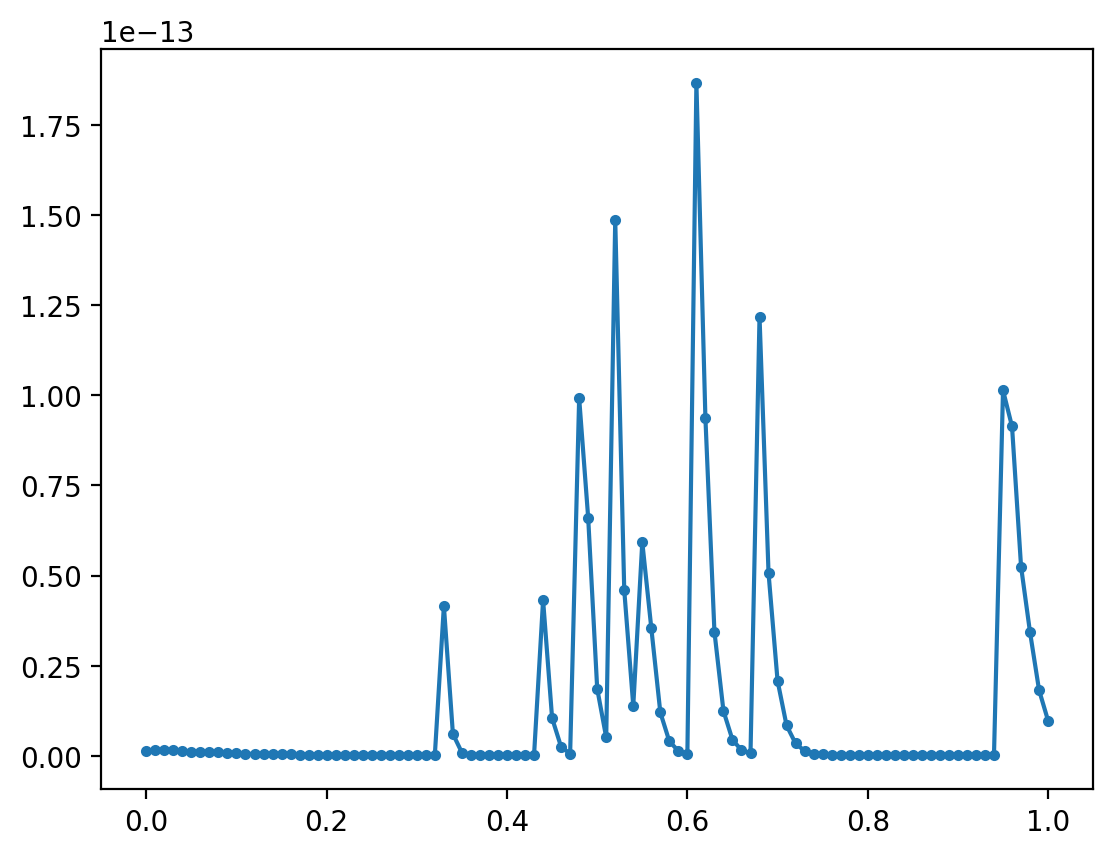

In [13]:
Npt = len(VTA_list)
norm_list = [np.linalg.norm((VTA_list[n] - G_list[n]).data_as(),ord='fro') for n in range(Npt)]
plt.plot(α_array,norm_list,'.-')
plt.show()

In [14]:
idx_maxErr = np.argmax(norm_list)
print(idx_maxErr)
print(qt.settings.core['atol'], VTA_list[idx_maxErr] == G_list[idx_maxErr])
qt.settings.core['atol'] = 1e-14
print(qt.settings.core['atol'], VTA_list[idx_maxErr] == G_list[idx_maxErr])
qt.settings.core['atol'] = 1e-12  #change back to default

61
1e-12 True
1e-14 False


## Transform from computational basis to eigenbasis

The bug and corrections (cell `In [8]:`) related to the analytical formula $\mathcal{G}$ were first looked into in the eigenbasis below: only (1,1),  (2,2), and (3,3) elements (triple-rank projector space) are different between VTA and $\mathcal{G}$ in the original code without corrections.

In [15]:
U = Qobj(np.hstack([vobj.data_as() for vobj in eigvecs]),dims=VTA_list[0].dims)
diagVTA_list = [(U.dag()*M*U).tidyup() for M in VTA_list]
diagG_list = [(U.dag()*M*U).tidyup() for M in G_list]

In [16]:
diagVTA_list[idx_maxErr]

Quantum object: dims=[[2, 2, 2, 2], [2, 2, 2, 2]], shape=(16, 16), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 7.50001896e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   2.16503067e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.68544521e-06  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.68544509e-06  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.68544521e-06
   0.00000000e+00  0.

In [17]:
diagG_list[idx_maxErr]

Quantum object: dims=[[2, 2, 2, 2], [2, 2, 2, 2]], shape=(16, 16), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 7.50001896e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   2.16503067e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.68544521e-06  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.68544521e-06  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.68544521e-06
   0.00000000e+00  0.